The Hamiltonian $\mathcal {H}$ and the angular momentum $L$ for the Kepler problem are

$$\mathcal {H} = \frac{1}{2}(\dot{q}^2_1+\dot{q}^2_2)-\frac{1}{\sqrt{q^2_1+q^2_2}},\quad
L = q_1\dot{q_2} - \dot{q_1}q_2$$

Also, we know that

$${\displaystyle {\frac {\mathrm {d} {\boldsymbol {p}}}{\mathrm {d} t}}=-{\frac {\partial {\mathcal {H}}}{\partial {\boldsymbol {q}}}}\quad ,\quad {\frac {\mathrm {d} {\boldsymbol {q}}}{\mathrm {d} t}}=+{\frac {\partial {\mathcal {H}}}{\partial {\boldsymbol {p}}}}}$$
# Kepler Problem
### Yingbo Ma, Chris Rackauckas

In [2]:
using OrdinaryDiffEq, LinearAlgebra, ForwardDiff, Plots; gr()
H(q,p) = norm(p)^2/2 - inv(norm(q))
L(q,p) = q[1]*p[2] - p[1]*q[2]

pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-H(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> H(q, p), p)

initial_position = [.4, 0]
initial_velocity = [0., 2.]
initial_cond = (initial_position, initial_velocity)
initial_first_integrals = (H(initial_cond...), L(initial_cond...))
tspan = (0,20.)
prob = DynamicalODEProblem(pdot, qdot, initial_velocity, initial_position, tspan)
sol = solve(prob, KahanLi6(), dt=1//10);

Let's plot the orbit and check the energy and angular momentum variation. We know that energy and angular momentum should be constant, and they are also called first integrals.

In [3]:
plot_orbit(sol) = plot(sol,vars=(3,4), lab="Orbit", title="Kepler Problem Solution")

function plot_first_integrals(sol, H, L)
    plot(initial_first_integrals[1].-map(u->H(u[2,:], u[1,:]), sol.u), lab="Energy variation", title="First Integrals")
    plot!(initial_first_integrals[2].-map(u->L(u[2,:], u[1,:]), sol.u), lab="Angular momentum variation")
end
analysis_plot(sol, H, L) = plot(plot_orbit(sol), plot_first_integrals(sol, H, L))

analysis_plot (generic function with 1 method)

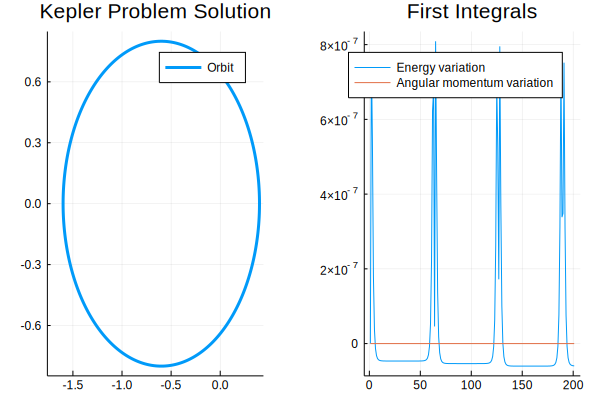

In [4]:
analysis_plot(sol, H, L)

Let's try to use a Runge-Kutta-Nyström solver to solve this problem and check the first integrals' variation.

sol2.u |> length = 79


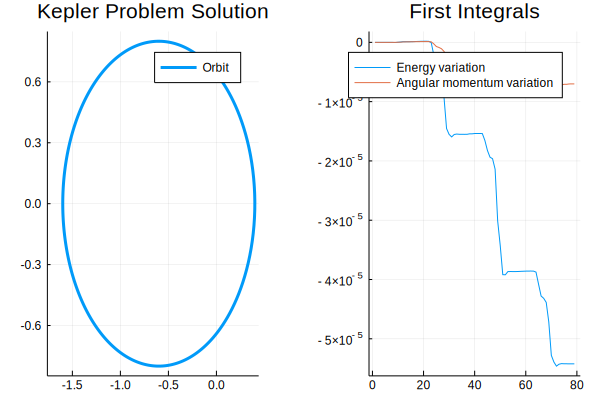

In [5]:
sol2 = solve(prob, DPRKN6())  # dt is not necessary, because unlike symplectic
                              # integrators DPRKN6 is adaptive
@show sol2.u |> length
analysis_plot(sol2, H, L)

Let's then try to solve the same problem by the `ERKN4` solver, which is specialized for sinusoid-like periodic function

sol3.u |> length = 52


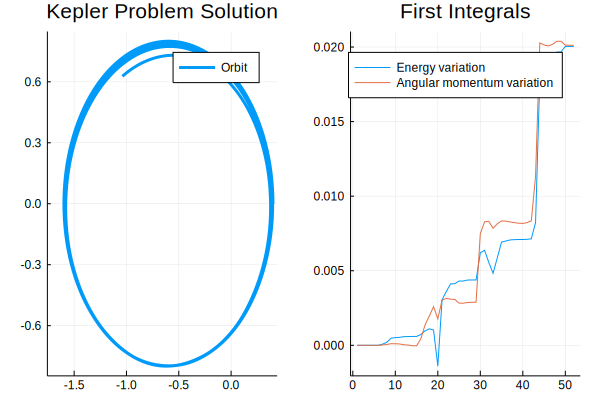

In [6]:
sol3 = solve(prob, ERKN4()) # dt is not necessary, because unlike symplectic
                            # integrators ERKN4 is adaptive
@show sol3.u |> length
analysis_plot(sol3, H, L)

We can see that `ERKN4` does a bad job for this problem, because this problem is not sinusoid-like.

One advantage of using `DynamicalODEProblem` is that it can implicitly convert the second order ODE problem to a *normal* system of first order ODEs, which is solvable for other ODE solvers. Let's use the `Tsit5` solver for the next example.

sol4.u |> length = 54


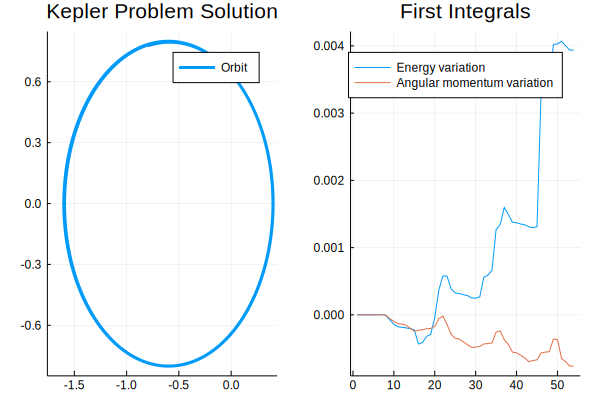

In [7]:
sol4 = solve(prob, Tsit5())
@show sol4.u |> length
analysis_plot(sol4, H, L)

#### Note

There is drifting for all the solutions, and high order methods are drifting less because they are more accurate.

### Conclusion

---

Symplectic integrator does not conserve the energy completely at all time, but the energy can come back. In order to make sure that the energy fluctuation comes back eventually, symplectic integrator has to have a fixed time step. Despite the energy variation, symplectic integrator conserves the angular momentum perfectly.

Both Runge-Kutta-Nyström and Runge-Kutta integrator do not conserve energy nor the angular momentum, and the first integrals do not tend to come back. An advantage Runge-Kutta-Nyström integrator over symplectic integrator is that RKN integrator can have adaptivity. An advantage Runge-Kutta-Nyström integrator over Runge-Kutta integrator is that RKN integrator has less function evaluation per step. The `ERKN4` solver works best for sinusoid-like solutions.

## Manifold Projection

In this example, we know that energy and angular momentum should be conserved. We can achieve this through mainfold projection. As the name implies, it is a procedure to project the ODE solution to a manifold. Let's start with a base case, where mainfold projection isn't being used.

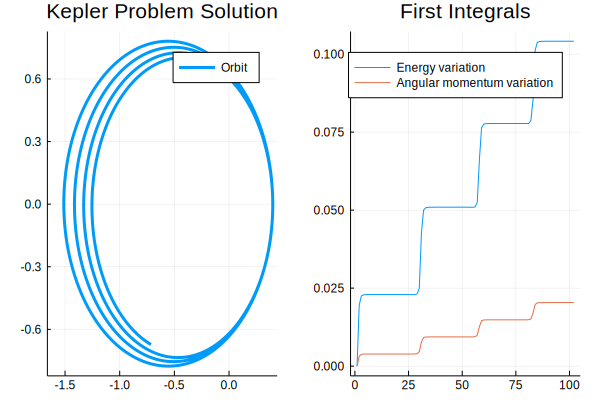

In [9]:
using DiffEqCallbacks

plot_orbit2(sol) = plot(sol,vars=(1,2), lab="Orbit", title="Kepler Problem Solution")

function plot_first_integrals2(sol, H, L)
    plot(initial_first_integrals[1].-map(u->H(u[1:2],u[3:4]), sol.u), lab="Energy variation", title="First Integrals")
    plot!(initial_first_integrals[2].-map(u->L(u[1:2],u[3:4]), sol.u), lab="Angular momentum variation")
end

analysis_plot2(sol, H, L) = plot(plot_orbit2(sol), plot_first_integrals2(sol, H, L))

function hamiltonian(du,u,params,t)
    q, p = u[1:2], u[3:4]
    qdot(@view(du[1:2]), p, q, params, t)
    pdot(@view(du[3:4]), p, q, params, t)
end

prob2 = ODEProblem(hamiltonian, [initial_position; initial_velocity], tspan)
sol_ = solve(prob2, RK4(), dt=1//5, adaptive=false)
analysis_plot2(sol_, H, L)

There is a significant fluctuation in the first integrals, when there is no mainfold projection.

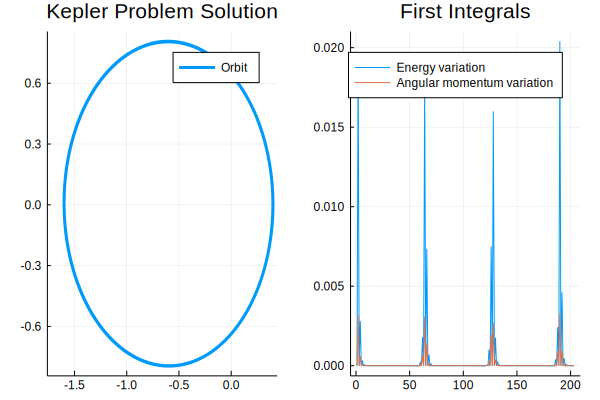

In [10]:
function first_integrals_manifold(residual,u)
    residual[1:2] .= initial_first_integrals[1] - H(u[1:2], u[3:4])
    residual[3:4] .= initial_first_integrals[2] - L(u[1:2], u[3:4])
end

cb = ManifoldProjection(first_integrals_manifold)
sol5 = solve(prob2, RK4(), dt=1//5, adaptive=false, callback=cb)
analysis_plot2(sol5, H, L)

We can see that thanks to the manifold projection, the first integrals' variation is very small, although we are using `RK4` which is not symplectic. But wait, what if we only project to the energy conservation manifold?

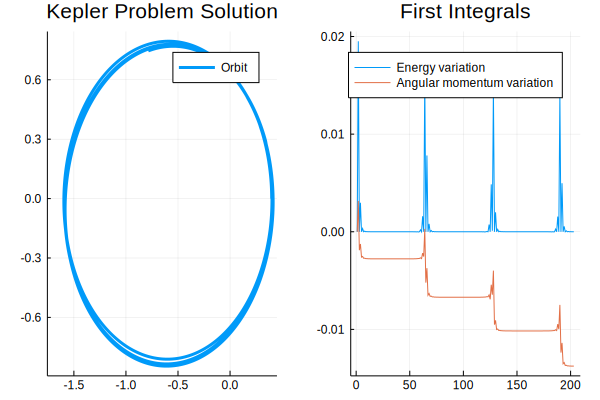

In [11]:
function energy_manifold(residual,u)
    residual[1:2] .= initial_first_integrals[1] - H(u[1:2], u[3:4])
    residual[3:4] .= 0
end
energy_cb = ManifoldProjection(energy_manifold)
sol6 = solve(prob2, RK4(), dt=1//5, adaptive=false, callback=energy_cb)
analysis_plot2(sol6, H, L)

There is almost no energy variation but angular momentum varies quite bit. How about only project to the angular momentum conservation manifold?

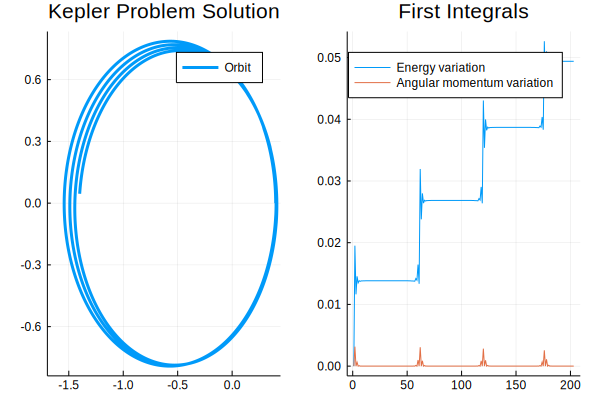

In [12]:
function angular_manifold(residual,u)
    residual[1:2] .= initial_first_integrals[2] - L(u[1:2], u[3:4])
    residual[3:4] .= 0
end
angular_cb = ManifoldProjection(angular_manifold)
sol7 = solve(prob2, RK4(), dt=1//5, adaptive=false, callback=angular_cb)
analysis_plot2(sol7, H, L)

Again, we see what we expect.